# Antibody Design -  test

These are the rules to complete this test:

- In this test, you will be asked to perform some analyses on antibody sequences using python, and return the results as a jupyter notebook in a git repository.
- The test should not take more than a couple of hours to complete. You can use any tools on internet, but you can't receive any external help.
- You should describe the protocol you have used to obtain the results, whenever it involves anything outside the jupyter notebook itself (e.g. databases, web tools, etc)
- The results of the test will be discussed in the 2nd interview

The sequence of the antibody we will analyse is the following:



>VH
QVQLKESGPGLVAPSQSLSITCTVSGFPLTAYGVNWVRQPPGKGLEWLGMIWGDGNTDYNSALKSRLSISKDNSKSQVFLKMNSLQTDDTARYYCARDPYGSKPMDYWGQGTSVTVSS
>VL
DIVMSQSPSSLVVSVGEKVTMSCKSSQSLLYSSNQKNFLAWYQQKPGQSPKLLIYWASTRESGVPDRFTGSGSGTDFTLTISSVKAEDLAVYYCQQYFRYRTFGGGTKLEIKRA

__Q1__ Install the package anarci, and using it retrieve the following information:
- germlines
- CDR sequences
- SHMs

In [1]:
# Creating csv for VH
!ANARCI -i QVQLKESGPGLVAPSQSLSITCTVSGFPLTAYGVNWVRQPPGKGLEWLGMIWGDGNTDYNSALKSRLSISKDNSKSQVFLKMNSLQTDDTARYYCARDPYGSKPMDYWGQGTSVTVSS --assign_germline --outfile VH --csv --scheme imgt --r H

# Creating csv for VL
!ANARCI -i DIVMSQSPSSLVVSVGEKVTMSCKSSQSLLYSSNQKNFLAWYQQKPGQSPKLLIYWASTRESGVPDRFTGSGSGTDFTLTISSVKAEDLAVYYCQQYFRYRTFGGGTKLEIKRA --assign_germline --outfile VL --csv --scheme imgt --r L

zsh:1: command not found: ANARCI
zsh:1: command not found: ANARCI


In [2]:
import pandas as pd

# Loading saved CSV
df_VH = pd.read_csv("ABDesign_case_H.csv")
df_VL = pd.read_csv("ABDesign_case_KL.csv")

In [3]:
aligned_VH = df_VH.iloc[:, 13:]
aligned_VL = df_VL.iloc[:, 13:]

In [4]:
# Providing overview of important information from the VH chain
VH_info = dict(
    v_gene=df_VH.v_gene.values[0],
    j_gene=df_VH.j_gene.values[0],
    CDR1="".join(aligned_VH.iloc[:, 26:38].values.tolist()[0]),
    CDR2="".join(aligned_VH.iloc[:, 55:65].values.tolist()[0]),
    CDR3="".join(aligned_VH.iloc[:, 104:117].values.tolist()[0]),
)
VH_info

{'v_gene': 'IGHV2-6-7*01',
 'j_gene': 'IGHJ4*01',
 'CDR1': 'GFPL----TAYG',
 'CDR2': 'IWGD---GNT',
 'CDR3': 'ARDPYG-SKPMDY'}

In [5]:
# Providing overview of important information from the VL chain
VL_info = dict(
    v_gene=df_VL.v_gene.values[0],
    j_gene=df_VL.j_gene.values[0],
    CDR1="".join(aligned_VL.iloc[:, 26:38].values.tolist()[0]),
    CDR2="".join(aligned_VL.iloc[:, 55:65].values.tolist()[0]),
    CDR3="".join(aligned_VL.iloc[:, 104:117].values.tolist()[0]),
)
VL_info

{'v_gene': 'IGKV8-30*01',
 'j_gene': 'IGKJ1*01',
 'CDR1': 'QSLLYSSNQKNF',
 'CDR2': 'WA-------S',
 'CDR3': 'QQYF-----RYRT'}

__Q2__ write a function that returns all the occurrences of the motifs NG, DG, NS, and DS, if they overlap at least partially with any of the CDRs

In [6]:
def occurences(sequence):
    """
    A function that counts the occurences of overlapping motifs with any CDRs.

    Assuming sequence is IMGT-numbered
    """
    motifs = ["NG", "DG", "NS", "DS"]  # A list to look up motifs
    motif_counts = dict(NG=0, DG=0, NS=0, DS=0)  # dict where we count each motif
    for i in range(
        len(sequence[25:39].replace("-", "")) - 1
    ):  # CDR1 - We add stem since we are interested in partially overlapping motifs
        motif = sequence[i] + sequence[i + 1]
        if motif in motifs:
            motif_counts[motif] += 1
    for i in range(len(sequence[54:66].replace("-", "")) - 1):  # CDR2
        motif = sequence[i] + sequence[i + 1]
        if motif in motifs:
            motif_counts[motif] += 1
    for i in range(len(sequence[103:118].replace("-", "")) - 1):  # CDR3
        motif = sequence[i] + sequence[i + 1]
        if motif in motifs:
            motif_counts[motif] += 1
    return motif_counts

In [7]:
occurences("".join(aligned_VL.values.tolist()[0]))

{'NG': 0, 'DG': 0, 'NS': 0, 'DS': 0}

In [8]:
occurences("".join(aligned_VH.values.tolist()[0]))

{'NG': 0, 'DG': 0, 'NS': 0, 'DS': 0}

No overlapping or partially overlapping motifs with CDRs were found in the sequences

__Q3__ These sites are potential liabilities in the antibody. Using online tools, and your own intuition, describe which othese occurences might be problematic, which residues you would suggest mutating to eliminate such liabilities minimizing the risk of affecting the antibody binding affinity, and why

If the motifs are found at CDR regions it can affect binding. As CDRs are the ones that interact with antigen it is likely that a change in motif in these regions lead to poor affinity. Thus, I would suggest mutating residues in the framework regions to minimize risk affecting antibody binding affinity

__Q4__ Using the online tool ABodybuilder, build a 3d structure for this antibody. On the structure, using pymol or any python library of your choice (e.g. BioPDB) identify the minimal distance between any atom of any residue in the CDR3 of the heavy and light chains. You will need to report the residue in the CDR3 of the havy chain and the atom, the residue in the CDFR3 of the light chain and the atom

In [9]:
from Bio.PDB.PDBParser import PDBParser

parser = PDBParser(PERMISSIVE=True)
structure_id = "ABDesign_case_rank1_imgt_scheme"
filename = "ABDesign_case_rank1_imgt_scheme.pdb"
model = parser.get_structure(structure_id, filename)[0]
chainH = model["H"]
chainL = model["L"]

In [10]:
# Here I chose CA of residue 114 of the heavy chain and calculated its distance to the CA of residue 107 in the light chain
chainH[114]["CA"] - chainL[107]["CA"]

7.928552

__Q5__ A library was constructed on the antibody by introducing variability in the CDR3 of the heavy chain, and the binding affinity was measured for each antibody in the library. The affinities are reported as -log10, so the higher values indicate the stronger binders. Can you provide the code to train an XGboost model on the train_data using the techniques you deem necessary to ensure the model robustness, and use it to predict the binding affinity of the antibody in the list _test_
Report the model performance in terms of RMSE, the predicted values for the test antibodies, and any comment on the model.

In [11]:
import numpy as np
import random
import string

# Define the number of data points
n_samples = 1000

# Define possible amino acids
amino_acids = list("ARNDCEQGHILKMFPSTWYV")


# Generate random CDR3 sequences
def generate_CDR3(length):
    return "".join(random.choice(amino_acids) for _ in range(length))


CDR3_sequences = [generate_CDR3(np.random.randint(15, 20)) for _ in range(n_samples)]

# Generate random scores between 0 and 10
scores = np.random.uniform(6, 10, n_samples)

# Create dataset
train_data = list(zip(CDR3_sequences, scores))

test_data = [
    "KYWRDGSTWWELIYGYG",
    "RQSFKFCCTFE",
    "LLWRYFFRKFSCD",
    "STLTFSDNIGSYPCWD",
    "QRLQEHTAGRG",
]

In [12]:
import sapiens


def get_sapiens_embedding(sequences):
    embs = []
    for seq in sequences:
        emb = sapiens.predict_sequence_embedding(seq, "H", layer=None)
        embs.append(emb)
    return np.array(embs)

2023-05-22 22:13:56 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX


In [13]:
train_embeddings = get_sapiens_embedding(CDR3_sequences)
test_embeddings = get_sapiens_embedding(test_data)

2023-05-22 22:13:56 | INFO | fairseq.file_utils | loading archive file /Users/augustehlers/miniconda3/envs/ABDesign_case/lib/python3.8/site-packages/sapiens/models/v1
2023-05-22 22:13:56 | INFO | fairseq.file_utils | loading archive file /Users/augustehlers/miniconda3/envs/ABDesign_case/lib/python3.8/site-packages/sapiens/models/v1
2023-05-22 22:13:57 | INFO | fairseq.tasks.masked_lm | dictionary: 24 types
2023-05-22 22:13:57 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'simple', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': 'data/models/human_heavy_chain_by_year/seq_random20M/13_unmasked_700epochs/tensorboard', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scal

I perform gridsearch and kfold cross validation in this case since the sequences are generated by random selection from the amino acids at random lengths. If these were real CDR3 sequences, I would expect more conservation at certain residues and would probably use something like a stratified k-fold CV to group similar sequences into the same fold. I want to predict how each of these mutations affect binding affinity and it will be harder for the model to learn if grouped randomly as in normal K-fold

Below I use the sklearn and a XGboost regressor to predict BA. I perform gridsearch over max depth of the tree, number of estimators and the embedding layers in the sapiens embeddings. I use Sapiens to model the sequences and obtain sequence embeddings. These are then scaled prior to PCA followed by fitting the model.

In [59]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import make_scorer
import xgboost as xgb


# Defining RMSE loss function
def rmse(actual, predicted):
    predicted = np.array(predicted)
    actual = np.array(actual)
    difference = predicted - actual
    squared_difference = difference**2
    mean_squared_difference = squared_difference.mean()
    rmse = np.sqrt(mean_squared_difference)
    return rmse


# Wrap the scorer to be used with sklearn
scorer = make_scorer(rmse, greater_is_better=False)


# Defining a base estimator to extract a given layer
class sapiens_embeddings(BaseEstimator, TransformerMixin):
    def __init__(self, layer=None):
        self.layer = layer

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        emb = X[:, self.layer, :]
        return emb


# Defining XGBRegressor
xgb_model = xgb.XGBRegressor()

# Defining a pipleline starting with obtaining the given embeddings, then scaling, then PCA and are then fed to the model
pipe = Pipeline(
    steps=[
        ("embeddings", sapiens_embeddings()),
        ("scale", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
        ("model", xgb_model),
    ]
)

# Define gridsearch using the pipeline and providing the parameters to search
clf = GridSearchCV(
    pipe,
    {
        "embeddings__layer": [0, 1, 2, 3, 4],
        "model__max_depth": [2, 4, 6],
        "model__n_estimators": [100, 200, 400, 800],
    },
    verbose=1,
    scoring=scorer,
    n_jobs=-1,
    cv=5,
    refit=True,
)

# Fit the model
clf.fit(train_embeddings, scores)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('embeddings', sapiens_embeddings()),
                                       ('scale', StandardScaler()),
                                       ('pca', PCA(n_components=0.95)),
                                       ('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_ty...
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'embeddings__layer': [0, 1, 2, 3, 4],
                         'model__max_depth': [2, 4, 6],
                         'model__n_estimators': [100, 200, 400, 800]},
             scoring=make_scorer(rmse, greater_is_better=False), verbose=1)

In [60]:
# Extracting best results
mean_score = clf.cv_results_["mean_test_score"][clf.best_index_]
print(f"Best parameters: {clf.best_params_}")
print(f"RMSE Mean CV score: {mean_score}")

Best parameters: {'embeddings__layer': 4, 'model__max_depth': 2, 'model__n_estimators': 100}
RMSE Mean CV score: -1.264551068079165


Visualizing train predictions vs true values

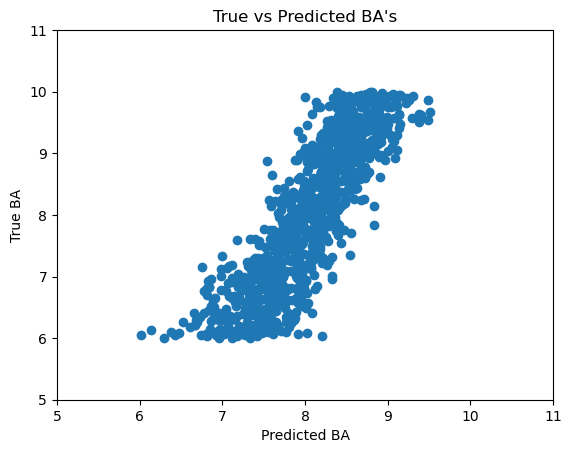

In [61]:
import matplotlib.pyplot as plt

train_y_pred = clf.predict(train_embeddings)
plt.scatter(train_y_pred, scores)
plt.xlim(5, 11)
plt.ylim(5, 11)
plt.xlabel("Predicted BA")
plt.ylabel("True BA")
plt.title("True vs Predicted BA's")
plt.show()

A linear trend is observed but predictions comes with high uncertainty.

Now I predict the test set

In [62]:
clf.predict(test_embeddings)

array([7.950748 , 7.6924105, 7.8638515, 8.012865 , 8.096401 ],
      dtype=float32)